In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [4]:
train_dir = os.path.join(os.getcwd(), "data", "FER-2013", "train")
test_dir = os.path.join(os.getcwd(), "data", "FER-2013", "test")

classes = os.listdir(train_dir)

label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}

In [5]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split="train", train_ratio=0.8):
        self.resize = Resize((48, 48))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ["train", "val"] and "train" in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels,
            )

            if split == "train":
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == "val":
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1
        return img, label

In [6]:
batch_size = 256
train_dataset = ImageDataset(train_dir, True, label2idx, split="train")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split="val")
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split="test")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

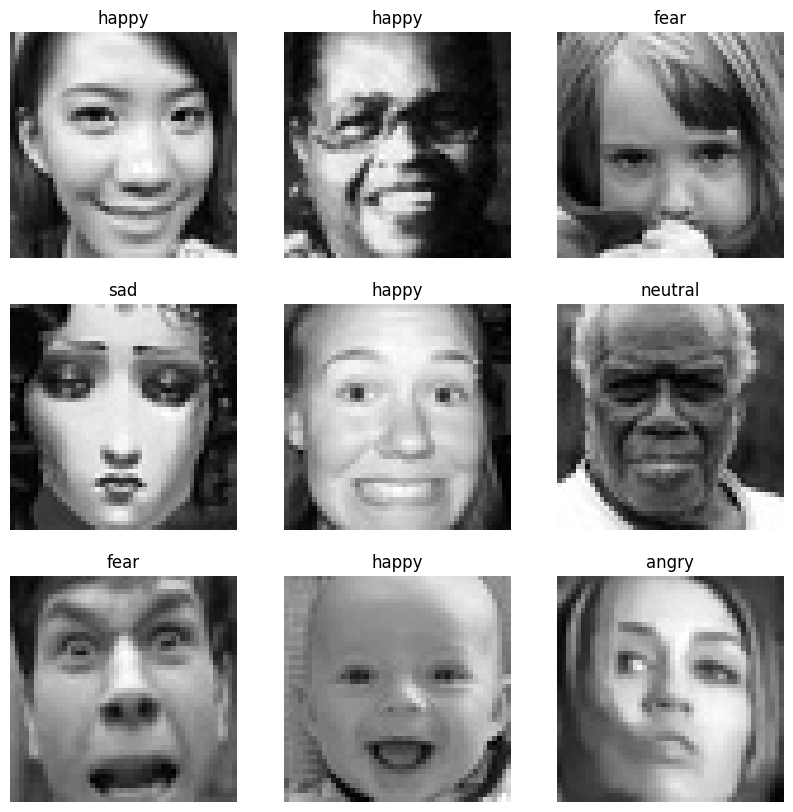

In [7]:
image_batch, label_batch = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims * 4)
        self.linear2 = nn.Linear(hidden_dims * 4, hidden_dims * 2)
        self.linear3 = nn.Linear(hidden_dims * 2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [9]:
input_dims = 48 * 48
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(
    device
)
model

MLP(
  (linear1): Linear(in_features=2304, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=7, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [12]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(
        f"\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}"
    )


EPOCH 1:	Training loss: 1.786	Validation loss: 1.692

EPOCH 2:	Training loss: 1.641	Validation loss: 1.645

EPOCH 3:	Training loss: 1.590	Validation loss: 1.609

EPOCH 4:	Training loss: 1.555	Validation loss: 1.596

EPOCH 5:	Training loss: 1.522	Validation loss: 1.605

EPOCH 6:	Training loss: 1.489	Validation loss: 1.593

EPOCH 7:	Training loss: 1.465	Validation loss: 1.587

EPOCH 8:	Training loss: 1.435	Validation loss: 1.603

EPOCH 9:	Training loss: 1.412	Validation loss: 1.612

EPOCH 10:	Training loss: 1.373	Validation loss: 1.650

EPOCH 11:	Training loss: 1.347	Validation loss: 1.612

EPOCH 12:	Training loss: 1.326	Validation loss: 1.634

EPOCH 13:	Training loss: 1.299	Validation loss: 1.621

EPOCH 14:	Training loss: 1.273	Validation loss: 1.688

EPOCH 15:	Training loss: 1.257	Validation loss: 1.663

EPOCH 16:	Training loss: 1.206	Validation loss: 1.713

EPOCH 17:	Training loss: 1.191	Validation loss: 1.694

EPOCH 18:	Training loss: 1.183	Validation loss: 1.712

EPOCH 19:	Training

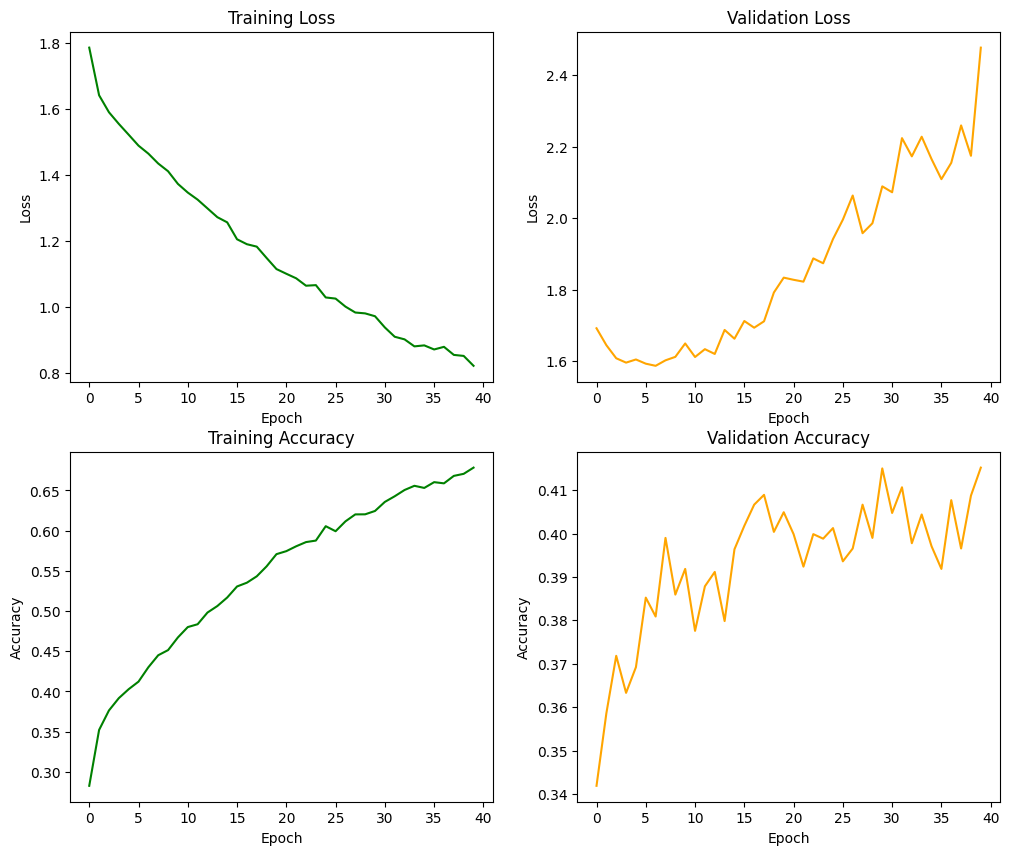

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color="green")
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, color="orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Validation Loss")

ax[1, 0].plot(train_accs, color="green")
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(val_accs, color="orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Validation Accuracy")

plt.show()

In [14]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)

val_acc = compute_accuracy(test_predict, test_target)
print("Evaluation on test set:")
print(f"Accuracy: {val_acc}")

Evaluation on test set:
Accuracy: 0.40986347171914184
